### 导入第三方库

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import datetime
from dateutil import relativedelta

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### 加载数据

In [3]:
data_raw = pd.read_csv('../data/train.csv', low_memory=False)
data_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
store_raw = pd.read_csv('../data/store.csv', low_memory=False)
store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
test_raw = pd.read_csv('../data/test.csv', low_memory=False)
test_raw.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


### 数据探索

#### 缺失数据情况

In [6]:
def display_missing(name, data):
    report = pd.DataFrame(columns=['column', 'missing', 'total'])
    for column in data.columns:
        null_col = pd.isna(data[column])
        if null_col.sum() > 0:
            report.loc[-1] = [column, null_col.value_counts()[True], data.shape[0]]
            report.index = report.index + 1
    display(name, report.sort_index())


In [7]:
display_missing('train data', data_raw)
display_missing('store data', store_raw)
display_missing('test data', test_raw)

'train data'

,column,missing,total


'store data'

,column,missing,total
0,PromoInterval,544,1115
1,Promo2SinceYear,544,1115
2,Promo2SinceWeek,544,1115
3,CompetitionOpenSinceYear,354,1115
4,CompetitionOpenSinceMonth,354,1115
5,CompetitionDistance,3,1115


'test data'

,column,missing,total
0,Open,11,41088


- 训练数据中没有缺失数据
- 附加商店数据中与促销相关的三个字段：PromoInterval, Promo2SinceYear, Promo2SinceWeek 均有554个缺失值；与竞争对手相关的三个字段：CompetitionOpenSinceYear, CompetitionOpenSinceMonth, CompetitionDistance分别有354, 354和3个缺失值
- 测试数据中Open这个字段有11个缺失值

#### 各个维度的基数

In [8]:
def display_cadinality(name, data):
    report = pd.DataFrame(columns=['column', 'cardinality', 'count'])
    for column in data.columns:
        report.loc[-1] = [column, len(data[column].unique()), data.shape[0]]
        report.index = report.index + 1
    display(name, report.sort_index())

In [9]:
display_cadinality('train data', data_raw)
display_cadinality('store data', store_raw)
display_cadinality('test data', test_raw)

'train data'

,column,cardinality,count
0,SchoolHoliday,2,1017209
1,StateHoliday,4,1017209
2,Promo,2,1017209
3,Open,2,1017209
4,Customers,4086,1017209
5,Sales,21734,1017209
6,Date,942,1017209
7,DayOfWeek,7,1017209
8,Store,1115,1017209


'store data'

,column,cardinality,count
0,PromoInterval,4,1115
1,Promo2SinceYear,8,1115
2,Promo2SinceWeek,25,1115
3,Promo2,2,1115
4,CompetitionOpenSinceYear,24,1115
5,CompetitionOpenSinceMonth,13,1115
6,CompetitionDistance,655,1115
7,Assortment,3,1115
8,StoreType,4,1115
9,Store,1115,1115


'test data'

,column,cardinality,count
0,SchoolHoliday,2,41088
1,StateHoliday,2,41088
2,Promo,2,41088
3,Open,3,41088
4,Date,48,41088
5,DayOfWeek,7,41088
6,Store,856,41088
7,Id,41088,41088


#### 商店情况

In [10]:
print('all stores of train are in store.csv?', all(x in set(store_raw['Store'].values) for x in set(data_raw['Store'].values)))
print('all stores of test  are in store.csv?', all(x in set(store_raw['Store'].values) for x in set(test_raw['Store'].values)))

print('open stores % in train data', data_raw['Open'].sum() / (len(data_raw)))
print('open stores % in test  data', test_raw['Open'].sum() / (len(test_raw)))

print('promo % in train data', data_raw['Promo'].sum() / (len(data_raw)))
print('promo % in test  data', test_raw['Promo'].sum() / (len(test_raw)))

print('state holiday % in train data', (data_raw['StateHoliday'] != '0').sum() / (len(data_raw)))
print('state holiday % in test  data', (test_raw['StateHoliday'] != '0').sum() / (len(test_raw)))

print('school holiday % in train data', (data_raw['SchoolHoliday'] != 0).sum() / (len(data_raw)))
print('school holiday % in test  data', (test_raw['SchoolHoliday'] != 0).sum() / (len(test_raw)))

all stores of train are in store.csv? True
all stores of test  are in store.csv? True
open stores % in train data 0.8301066939045958
open stores % in test  data 0.8540936526479751
promo % in train data 0.3815145166824124
promo % in test  data 0.3958333333333333
state holiday % in train data 0.03052470043029505
state holiday % in test  data 0.004380841121495327
school holiday % in train data 0.17864666946517382
school holiday % in test  data 0.4434871495327103


- 从各个字段的基数来看，测试和训练中出现的商店，共1115个，都包含在store data中，数据的对齐比较容易
- 训练数据的量级在100万左右，足够用来划分数据集和验证集
- 从部分特征统计结果来看，测试数据与训练数据的分布大体一致

#### 时间分布

In [11]:
print('train periode:', data_raw['Date'].min(), data_raw['Date'].max())
print('test  periode:', test_raw['Date'].min(), test_raw['Date'].max())
print('test dates count:', len(test_raw['Date'].unique()))
print('expected stores count:', len(test_raw.index) / len(test_raw['Date'].unique()))

train periode: 2013-01-01 2015-07-31
test  periode: 2015-08-01 2015-09-17
test dates count: 48
expected stores count: 856.0


- 训练数据包含大概2年零7个月的数据
- 测试数据包含大概6个星期的数据，时间刚好紧靠训练数据的时间之后
- 从特征分布上的一致性加上时间分布上的连续性来看，目前不必过于担忧训练数据与真实情况之间的差异而造成的巨大方差

#### 销售情况

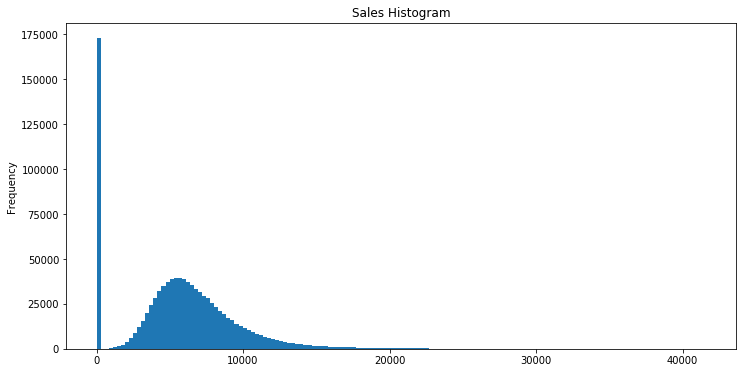

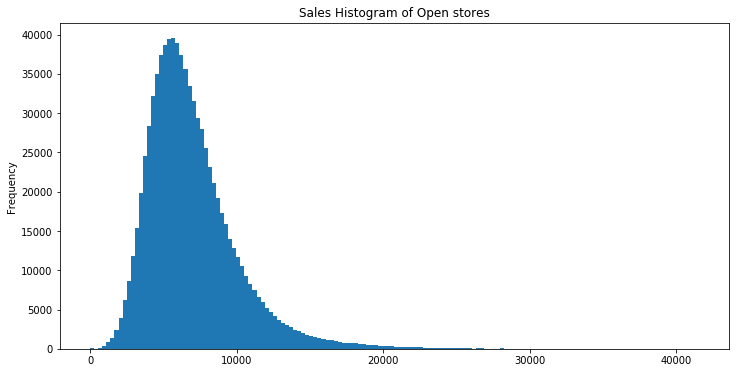

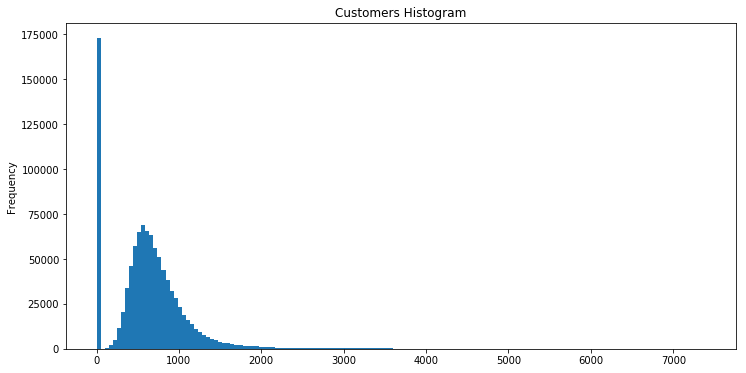

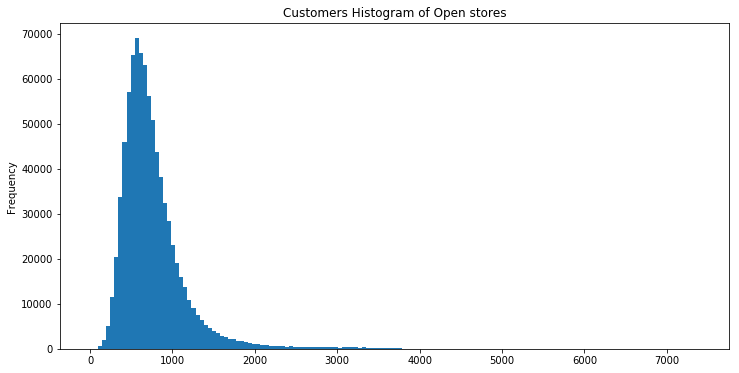

In [12]:
plt.figure()
data_raw['Sales'].plot(kind='hist', bins=150, figsize=(12,6), title='Sales Histogram')
plt.figure()
data_raw[data_raw['Open'] == 1]['Sales'].plot(kind='hist', bins=150, figsize=(12,6), title='Sales Histogram of Open stores')
plt.figure()
data_raw['Customers'].plot(kind='hist', bins=150, figsize=(12,6), title='Customers Histogram')
plt.figure()
data_raw[data_raw['Open'] == 1]['Customers'].plot(kind='hist', bins=150, figsize=(12,6), title='Customers Histogram of Open stores')

销售额与客户数分布相似，它们之间很有可能有关联，进一步观察数据

,Sales,Customers
Sales,1.000000,0.894711
Customers,0.894711,1.000000


<Figure size 432x288 with 0 Axes>

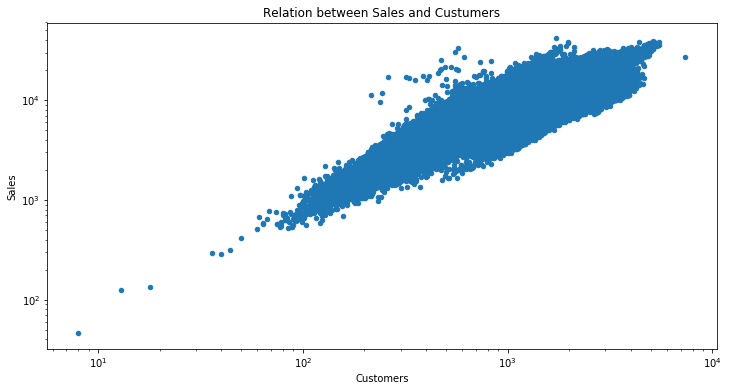

In [13]:
plt.figure()
ax = data_raw[(data_raw['Sales'] > 0) & (data_raw['Customers'] > 0)].plot(kind='scatter', x='Customers', y='Sales', 
                                    logx=True, logy=True, figsize=(12,6), title='Relation between Sales and Custumers')
data_raw[['Sales', 'Customers']].corr()

- 顾客数与销售额有很强的相关性(0.895)，这与现实生活中的观察一致，然而这个信息并不能帮助我们来预测销售额，因为顾客数与销售额一样，都无法提前知道，所以也不会出现在测试数据中，顾客数并不是我们可以利用的特征。

#### 下面随机选取一些商店的销售情况来进一步观察数据特征

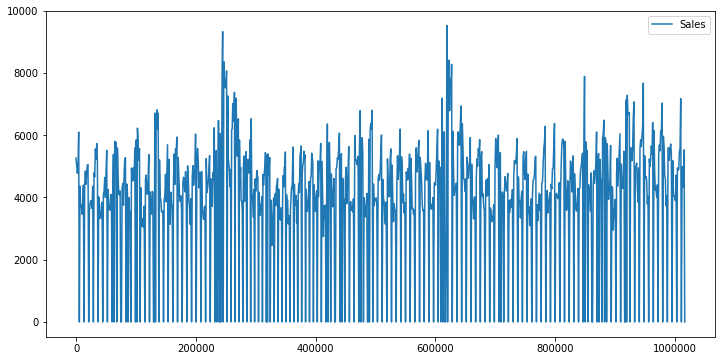

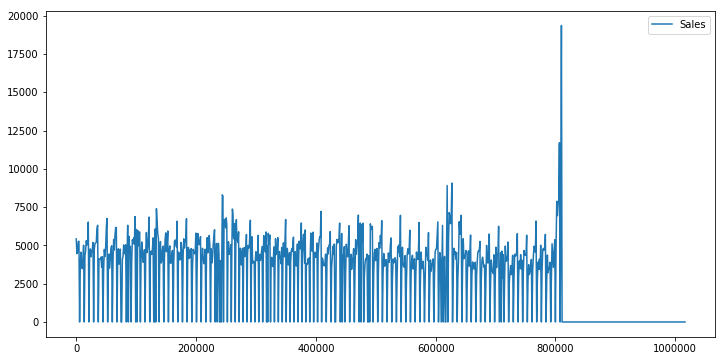

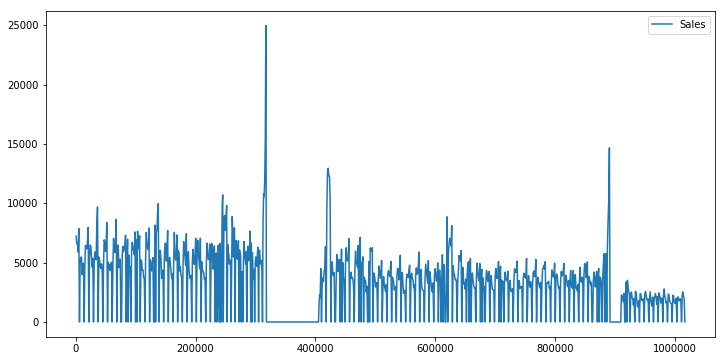

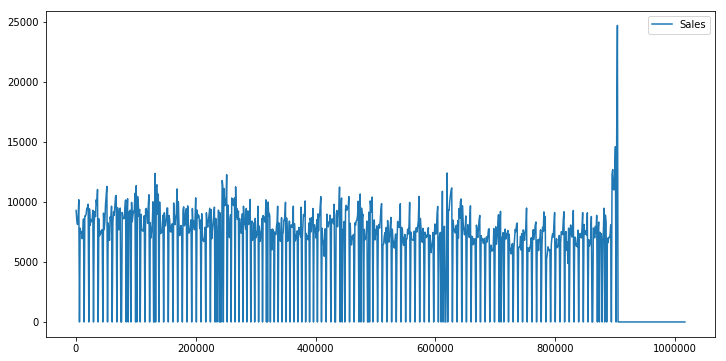

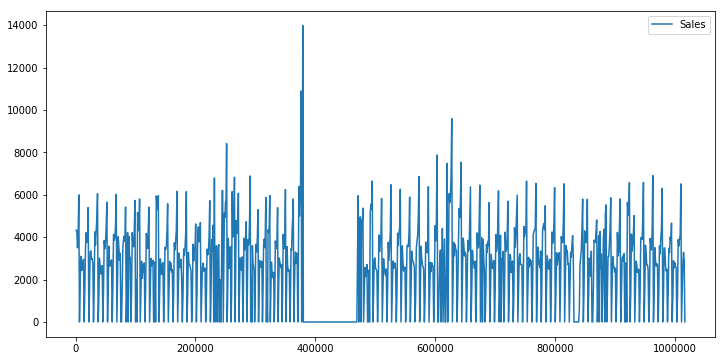

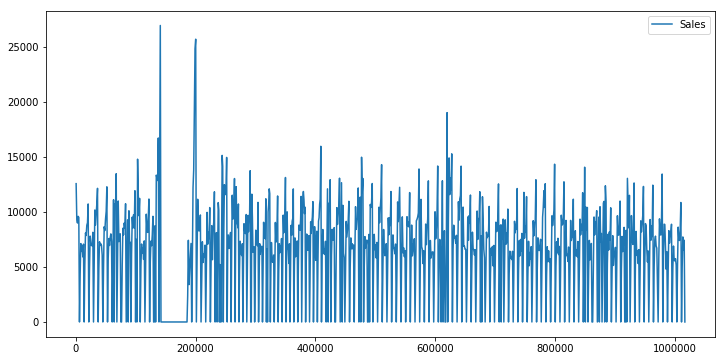

In [38]:
store_1 = data_raw[data_raw['Store'] == 1]
store_1[['Sales']].plot(figsize=(12,6))
store_103 = data_raw[data_raw['Store'] == 103]
store_103[['Sales']].plot(figsize=(12,6))
store_708 = data_raw[data_raw['Store'] == 708]
store_708[['Sales']].plot(figsize=(12,6))
store_349 = data_raw[data_raw['Store'] == 349]
store_349[['Sales']].plot(figsize=(12,6))
store_972 = data_raw[data_raw['Store'] == 972]
store_972[['Sales']].plot(figsize=(12,6))
store_674 = data_raw[data_raw['Store'] == 674]
store_674[['Sales']].plot(figsize=(12,6))
plt.show()

以上图线反应出几个重要信息：
- 每个商店都包含大量的0销售额，不难推测，其中应该包含周末和商店关门的日期
- 有的商店出现连续一周以上的0销售额，这个应该对应项目介绍中提到的装修
- 由于装修的时间是通过0销售额的分布决定的，为了保存这部分关键信息，不应该将所有为0销售额的数据剔除
- 然而0销售额必然对模型造成严重干扰，需要将它们作为异常信息进行处理

#### 假期与促销对销售的影响

<Figure size 432x288 with 0 Axes>

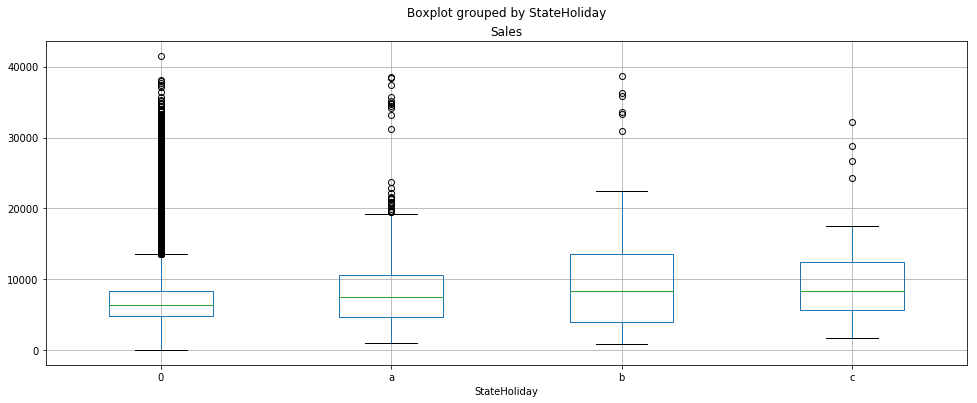

<Figure size 432x288 with 0 Axes>

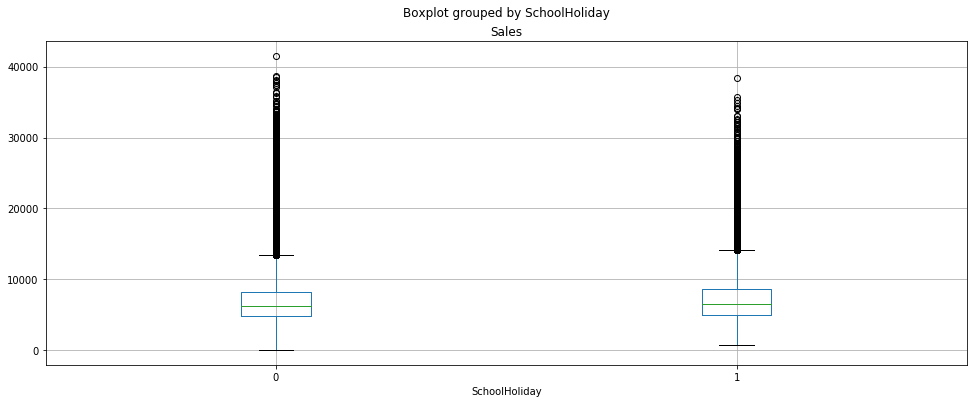

In [15]:
plt.figure()
data_raw[data_raw['Sales'] > 0].boxplot(column=['Sales'], by='StateHoliday', figsize=(16,6))
plt.figure()
data_raw[data_raw['Sales'] > 0].boxplot(column=['Sales'], by='SchoolHoliday', figsize=(16,6))

average sales per customer without promo: 8.941127696725117
average sales per customer with promo: 10.178906892166443


<Figure size 432x288 with 0 Axes>

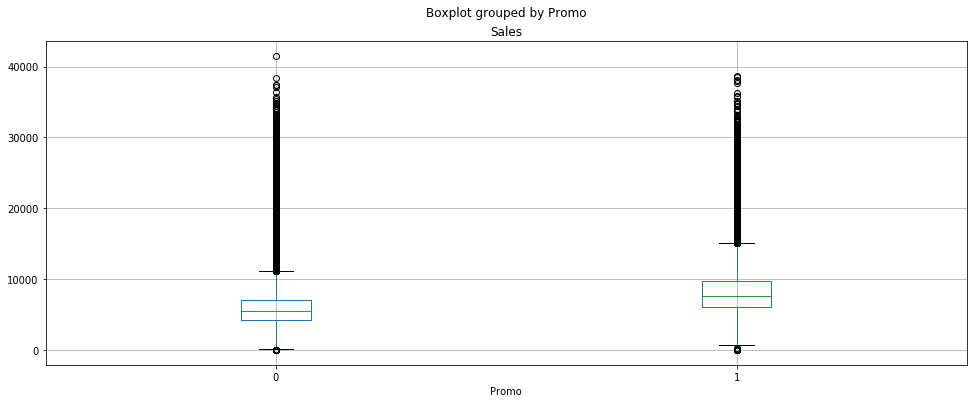

In [16]:
plt.figure()
data_raw[data_raw['Open'] == 1].boxplot(column=['Sales'], by='Promo', figsize=(16,6))
df_nopromo = data_raw[data_raw['Promo'] == 0]
df_promo = data_raw[data_raw['Promo'] == 1]
print('average sales per customer without promo:', (df_nopromo['Sales'] / df_nopromo['Customers']).mean())
print('average sales per customer with promo:', (df_promo['Sales'] / df_promo['Customers']).mean())

显然，销售额受假期以及促销的影响比较明显，另外，不开业的商店销售额必然为零，那么接下来把这几个因素放到一起以表格的形式综合分析

In [17]:
print('Sales should be zero when store is closed:', data_raw[data_raw['Open'] == 0]['Sales'].sum() == 0)
data_raw.groupby(['StateHoliday', 'SchoolHoliday', 'Promo'])['Sales'].sum()

Sales should be zero when store is closed: True


StateHoliday  SchoolHoliday  Promo
0             0              0        2241608865
                             1        2449432660
              1              0         526415615
                             1         647707628
a             0              0           1937757
                             1           3072562
              1              0            565309
                             1            314677
b             0              0             97829
                             1            110858
              1              0            657156
                             1            567901
c             1              0            691806
Name: Sales, dtype: int64

- 大多数情况下，促销对销售都有积极影响
- 然而在法定假日与学校假日同时出现时，促销并没有带来积极影响

比较特殊的是，开业的商店销售额却为0，来看看这样的情况有多少

In [18]:
zero_sales = data_raw[(data_raw['Open'] == 1) & (data_raw['Sales'] == 0)]
print(len(zero_sales.index), 'sales with 0 value when store is open')
print(len(zero_sales['Store'].unique()), 'sotres are in this case')
display(zero_sales['Promo'].value_counts())
display(zero_sales['StateHoliday'].value_counts())
display(zero_sales['SchoolHoliday'].value_counts())
print('maximum 0 sale days:', zero_sales.groupby('Store')['Date'].count().max())

54 sales with 0 value when store is open
41 sotres are in this case


0    33
1    21
Name: Promo, dtype: int64

0    54
Name: StateHoliday, dtype: int64

0    42
1    12
Name: SchoolHoliday, dtype: int64

maximum 0 sale days: 3


- 开业时，零销售额的出现属于个别特例

#### 除了假日之外，周末对销售的影响应当也比较明显

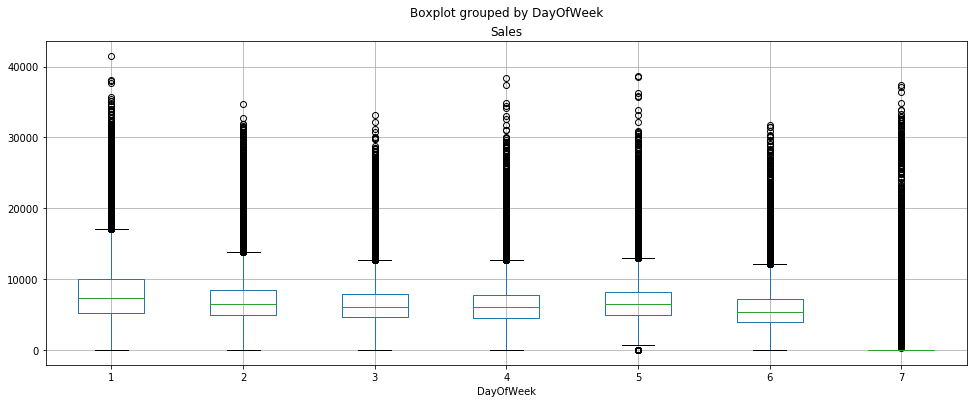

In [19]:
data_raw.boxplot(column=['Sales'], by='DayOfWeek', figsize=(16,6))

猜测原因应该是大部分商店在周日关门，下面来验证一下

In [20]:
weekend_sales = data_raw[data_raw['DayOfWeek'] == 7]
weekend_sales['Open'].value_counts() / len(weekend_sales.index)

0    0.975174
1    0.024826
Name: Open, dtype: float64

### 商店数据

- 商店数据与训练/测试数据可以通过Store这个字段进行关联
- 商店相关信息不随时间变化，关联方向为销售数据指向商店数据

#### 概况

In [21]:
store_raw.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


- 商店类型分布情况

In [22]:
store_raw['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

- 品种分布情况

In [23]:
store_raw['Assortment'].value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

- 促销分布情况

In [24]:
store_raw['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

### 竞争对手情况

**竞争对手距离分布**

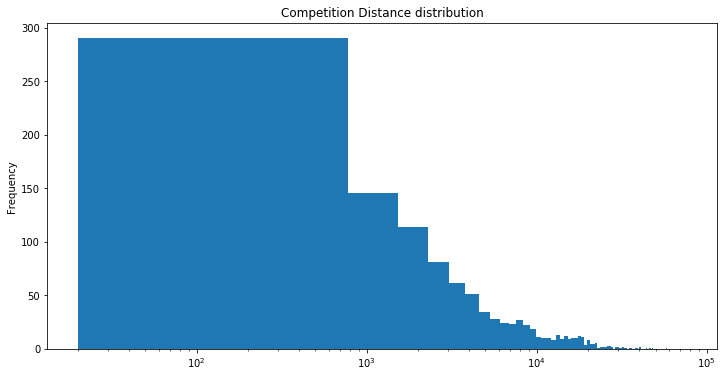

In [25]:
plt.figure()
ax = store_raw['CompetitionDistance'].plot(kind='hist', bins=100, figsize=(12,6), title='Competition Distance distribution')
ax.set_xscale('log')

- 绝大部分竞争对手都在商店附近
- 推测这一现象的原因是大部分商店都集中在大城市的商业中心，所以不是因为竞争对手故意将商店开在附近，而是所有商店都选择开在人流量大的地段

**竞争对手开业时间情况**

In [26]:
store_raw['CompetitionOpenSince'] = store_raw['CompetitionOpenSinceYear'].fillna(0).astype(int).map(str) + '-' + store_raw['CompetitionOpenSinceMonth'].fillna(0).astype(int).map(str)
store_raw['CompetitionOpenSince'].value_counts().head(10)

0-0        354
2012-9      31
2012-11     17
2013-4      14
2009-9      14
2013-9      12
2005-4      11
2008-9      11
2006-9      10
2005-12     10
Name: CompetitionOpenSince, dtype: int64

- 有354项缺失数据
- 其余的开业时间处于2012年至2013年的较多

转换为距离测试数据对应的开始时间， 即2015-08-01

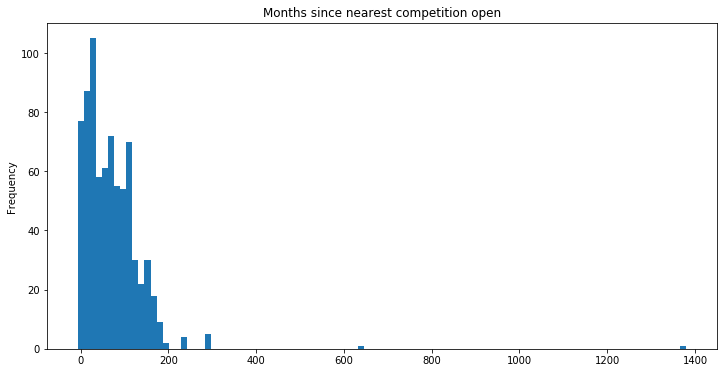

In [27]:
#As of 2015-08-01
now = datetime.datetime.strptime('2015-08-01', '%Y-%M-%d')
store_raw['CompetitionOpenMonths'] = (now.year - store_raw['CompetitionOpenSinceYear']) * 12 + (now.month - store_raw['CompetitionOpenSinceMonth'])
plt.figure()
store_raw['CompetitionOpenMonths'].plot(kind='hist', bins=100, figsize=(12,6), title='Months since nearest competition open')

- 大部分竞争对手都在十五年之内开业

In [28]:
store_sales = pd.merge(data_raw[data_raw['Sales'] > 0], store_raw, left_on='Store', right_on='Store', how='left')

**销售额与竞争对手距离的关系**

<Figure size 432x288 with 0 Axes>

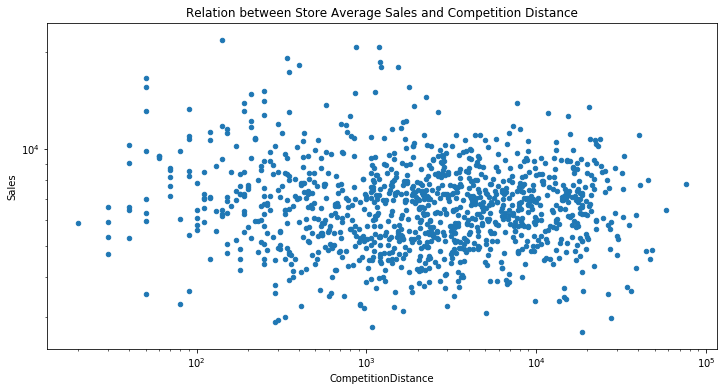

In [29]:
plt.figure()
average_store_sales = store_sales.groupby(['Store'])[['Sales', 'CompetitionDistance']].mean()
average_store_sales.plot(kind='scatter', x='CompetitionDistance', y='Sales', 
                                    logx=True, logy=True, figsize=(12,6), title='Relation between Store Average Sales and Competition Distance')

- 情况有一些反直觉，距离竞争对手近一些的销售额要偏高
- 这里说明地理位置的影响更重要，因为好的地理位置带来高的销售额，无论竞争对手的多少\

#### 促销特征

In [30]:
plt.figure()
store_raw['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

<Figure size 432x288 with 0 Axes>

- 促销的间隔期均为3个月，只是开始时间不同

**促销时长分布**

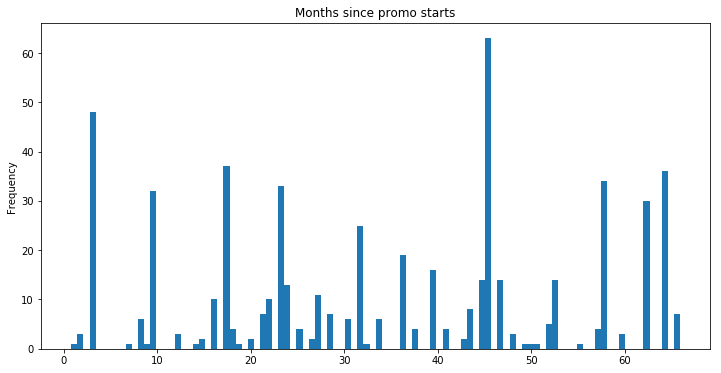

In [31]:
store_raw['Promo2Since'] = store_raw['Promo2SinceYear'].fillna(2100).astype(int).map(str) + '-' + store_raw['Promo2SinceWeek'].fillna(1).astype(int).map(str) + '-1'
store_raw['Promo2SinceTime'] = pd.to_datetime(store_raw['Promo2Since'], format='%Y-%U-%w')
store_raw['Promo2Duration'] = (now - store_raw['Promo2SinceTime']).map(lambda x: x.days / 30)
plt.figure()
store_raw['Promo2Duration'][store_raw['Promo2Duration'] > 0].plot(kind='hist', bins=100, figsize=(12,6), title='Months since promo starts')

- 促销时长分布没有明显规律

## 销售数据

#### 商店在时间维度上的销售曲线

<Figure size 432x288 with 0 Axes>

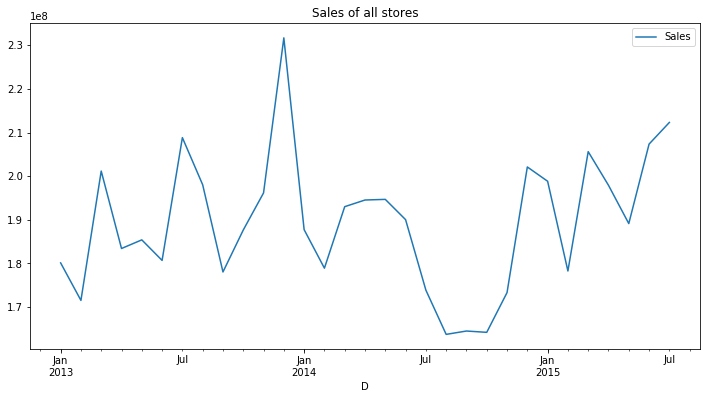

In [32]:
store_sales['D'] = pd.to_datetime(store_sales['Date'])
sales_by_month = store_sales.resample('M', on='D').sum()
sales_by_month['Date'] = sales_by_month.index
plt.figure()
sales_by_month.plot(y = 'Sales', figsize=(12,6), title='Sales of all stores')

- 销售额在时间上有明显的周期波动，猜测有潜在的季节性
- 后面进一步分析季节性

不同类型商店的销售情况

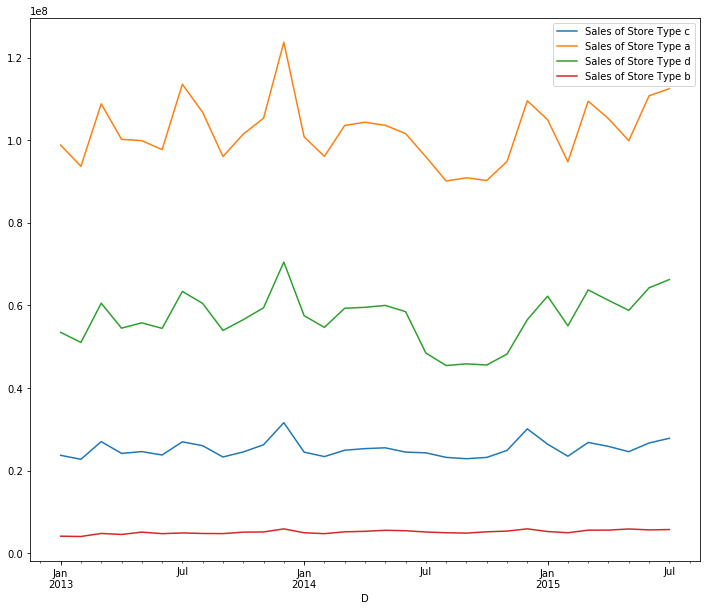

In [33]:
fig, ax = plt.subplots(figsize=(12,10))
for idx,store_type in enumerate(store_sales['StoreType'].unique()):
    sales_by_month = store_sales[store_sales['StoreType'] == store_type].resample('M', on='D').sum()
    sales_by_month.plot(y = 'Sales', subplots=True, label='Sales of Store Type ' + store_type, ax=ax, color='C' + str(idx))

- 不同的商店类型的销售额所在区间完全不同
- 商店类型是一个影响销售额的重要因素

不同品种的销售情况

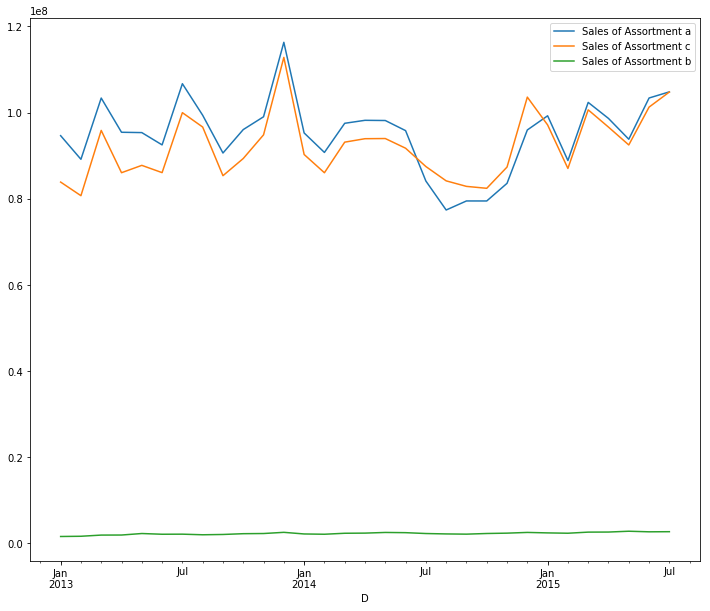

In [34]:
fig, ax = plt.subplots(figsize=(12,10))
for idx,assortment in enumerate(store_sales['Assortment'].unique()):
    sales_by_month = store_sales[store_sales['Assortment'] == assortment].resample('M', on='D').sum()
    sales_by_month.plot(y = 'Sales', subplots=True, label='Sales of Assortment ' + assortment, ax=ax, color='C' + str(idx))

- 同理，不同的品种对销售额也有较大影响

#### 季节性分析

In [35]:
season_sales = store_sales[['Sales', 'D', 'Store']].copy()
season_sales['Year'] = season_sales['D'].map(lambda d: d.year)
season_sales['Month'] = season_sales['D'].map(lambda d: d.month)
store_means = season_sales.groupby('Store')[['Sales']].mean()

In [36]:
store_means['Store'] = store_means.index
store_means.rename(columns = {'Sales':'StoreMean'}, inplace = True)
seasonal_data = pd.merge(season_sales, store_means, left_on='Store', right_on='Store', how='left')
seasonal_data['RelativeSales'] = seasonal_data['Sales'] / seasonal_data['StoreMean'] * 100
seasonal_data.head()

C:\Users\yunbo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'Store' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


,Sales,D,Store,Year,Month,StoreMean,RelativeSales
0,5263,2015-07-31,1,2015,7,4759.096031,110.588229
1,6064,2015-07-31,2,2015,7,4953.900510,122.408595
2,8314,2015-07-31,3,2015,7,6942.568678,119.753947
3,13995,2015-07-31,4,2015,7,9638.401786,145.200421
4,4822,2015-07-31,5,2015,7,4676.274711,103.116269


#### 下面的图做了如下处理
- 销售额用相对于商店平均销售额的百分数来表示
- 相对销售额对月份取平均数
- 目的是大幅减少缺失数据和商店关门造成的影响

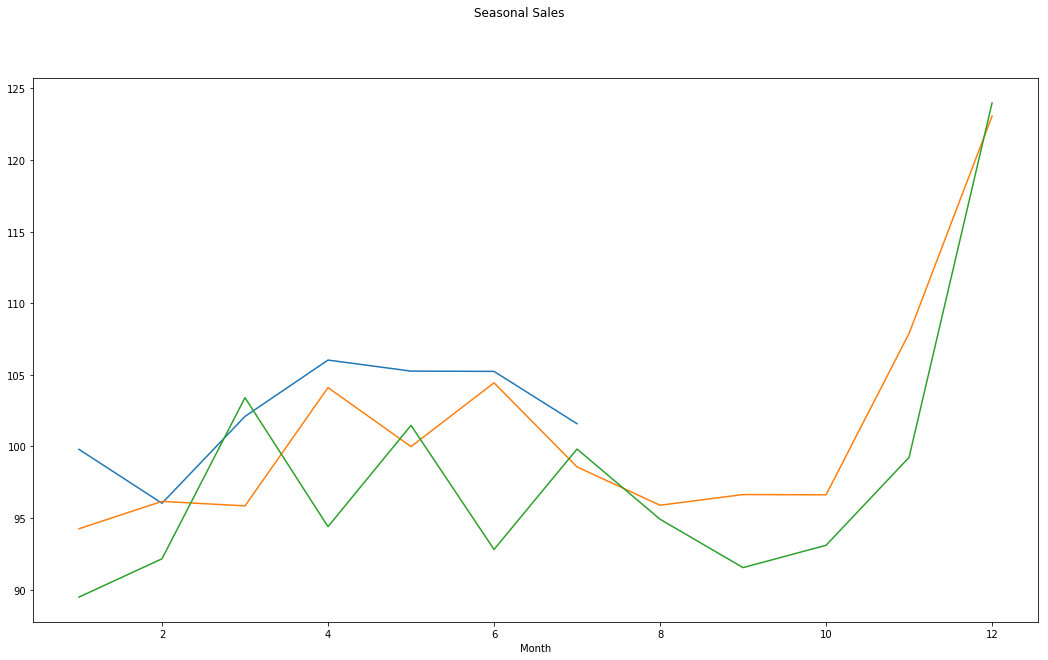

In [37]:
fig, ax = plt.subplots(figsize=(18,10))
years = seasonal_data['Year']
for idx,year in enumerate(years.unique()):
    data_year = seasonal_data[years == year].copy()
    sales_by_month = data_year.groupby('Month')['RelativeSales'].mean()
    sales_by_month.plot(y = 'RelativeSales', x = 'Month', subplots=True, label=str(year), ax=ax, color='C' + str(idx), title='Seasonal Sales')

- 从以上图看出，销售额的季节性非常明显
- 例如: 1，2月的低销售额，11，12月的高销售额是普遍现象